In [1]:
%matplotlib inline

In [2]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def loadImages(trainlocation, imageTransform):
    imageset = torchvision.datasets.ImageFolder(root = trainlocation, 
                                                transform=imageTransform)
    trainset, testset, validset = torch.utils.data.random_split(imageset, [0.7, 0.15, 0.15])
    trainimageloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True,
                                            num_workers=8)
    
    testimageloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True,
                                            num_workers=8)
    valimageloader = torch.utils.data.DataLoader(validset, batch_size=32, shuffle=True,
                                            num_workers=8)
    classes = ["F", "I1", "I2", "I3", "I4", "I5", "L4", "L5", "N", "O4", "P", "T4", "T5", "U", "V3", "V5", "W", "X", "Y", "Z4", "Z5"]
    return ({'train': trainimageloader, 'test': testimageloader, 'val': valimageloader, 'classes': classes}, len(trainset), len(validset))
    


def imshow(img):
    npimg = img.numpy()
    trans = np.transpose(npimg, (1, 2, 0))
    plt.imshow(trans)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


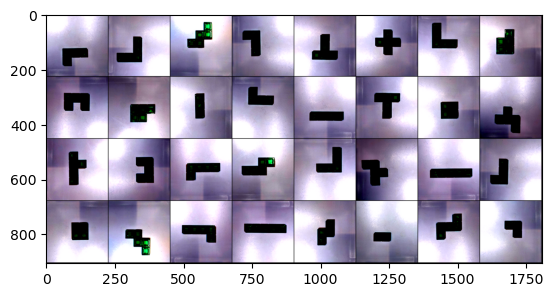

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


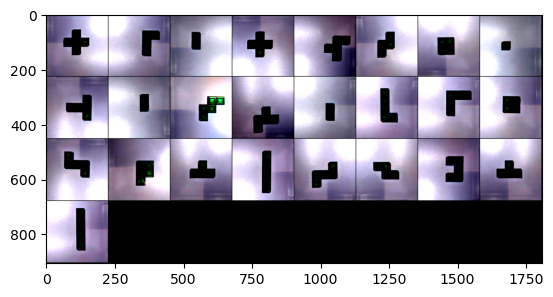

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


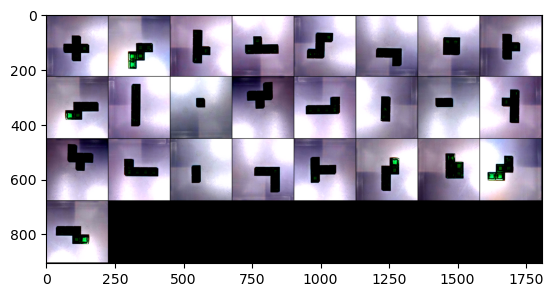

In [22]:
images, trainlen, testlen = loadImages("TrainingImages/ProcessedEverythingColor", models.ResNet50_Weights.DEFAULT.transforms())
batch, labels = next(iter(images['train']))
imshow(torchvision.utils.make_grid(batch))
batch, labels = next(iter(images['test']))
imshow(torchvision.utils.make_grid(batch))
batch, labels = next(iter(images['val']))
imshow(torchvision.utils.make_grid(batch))


In [23]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

In [24]:
import torch.optim as optim
import copy
import time

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  testaccuracy = []
  length = {"train": trainlen, "val": testlen}
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  since = time.time()

  best_model_wts = copy.deepcopy(net.state_dict())
  best_acc = 0.0

  for epoch in range(epochs):
      print(f'Epoch {epoch}/{epochs - 1}')
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              net.train()  # Set model to training mode
          else:
              net.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloader[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = net(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / length[phase]
          epoch_acc = running_corrects.double() / length[phase]
          losses.append(epoch_loss)
          testaccuracy.append(epoch_acc)

          print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(net.state_dict())

      print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  net.load_state_dict(best_model_wts)
  return (losses, testaccuracy)

In [25]:
def createModel(numClasses):
    resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    resnet.fc = nn.Linear(2048, numClasses)

    for name, param in resnet.named_parameters():
        if 'fc' not in name:
            param.requires_grad=False
    return resnet


Epoch 0/19
----------
train Loss: 3.0158 Acc: 0.0847
val Loss: 3.1176 Acc: 0.0000

Epoch 1/19
----------
train Loss: 2.4538 Acc: 0.5424
val Loss: 3.0789 Acc: 0.0000

Epoch 2/19
----------
train Loss: 1.6761 Acc: 0.8220
val Loss: 2.7979 Acc: 0.0800

Epoch 3/19
----------
train Loss: 0.8852 Acc: 0.9915
val Loss: 2.5458 Acc: 0.2000

Epoch 4/19
----------
train Loss: 0.4984 Acc: 1.0000
val Loss: 2.3202 Acc: 0.2800

Epoch 5/19
----------
train Loss: 0.4183 Acc: 0.9915
val Loss: 2.1038 Acc: 0.3600

Epoch 6/19
----------
train Loss: 0.1512 Acc: 1.0000
val Loss: 1.7501 Acc: 0.5200

Epoch 7/19
----------
train Loss: 0.1099 Acc: 1.0000
val Loss: 1.5614 Acc: 0.5600

Epoch 8/19
----------
train Loss: 0.1273 Acc: 1.0000
val Loss: 1.4199 Acc: 0.6400

Epoch 9/19
----------
train Loss: 0.1061 Acc: 1.0000
val Loss: 1.3291 Acc: 0.7200

Epoch 10/19
----------
train Loss: 0.1017 Acc: 1.0000
val Loss: 1.2549 Acc: 0.7600

Epoch 11/19
----------
train Loss: 0.0944 Acc: 1.0000
val Loss: 1.2192 Acc: 0.7600

Ep

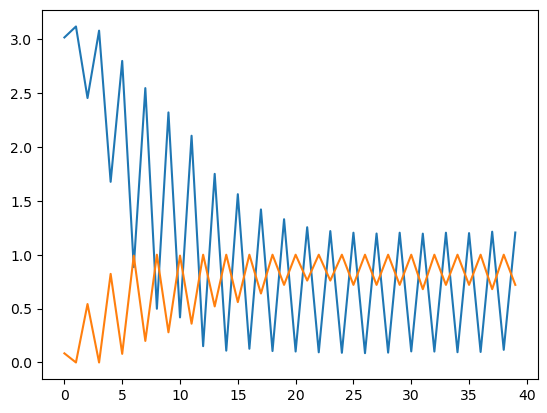

In [28]:
blockmodel = createModel(len(images['classes']))
blockmodel.train()
data = train(blockmodel, images, epochs=20, lr= 0.1)
plt.plot(data[0])
plt.plot(data[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Data


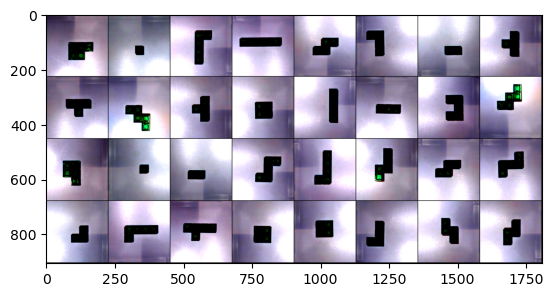

GroundTruth:      P    I1    L5    I5    Z4    L4    I2    T4    T4     W    T4    O4    I4    I3     U     W     P    I1    I2    Z5    L5     N    Z4    Z5    V3    L5     Y    O4    O4    L4    Z4    Z4
Predicted:      P    I1    L5    I5    Z4    L4    I2    T4    T4     W    T4    O4    I4    I3     U     W     P    I1    I2    Z5    L5     N    Z4    Z5    V3    L5     Y    O4    O4    L4    Z4    Z4
Accuracy:  1.0
Validation Data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


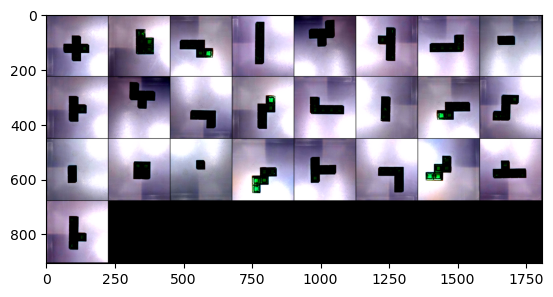

GroundTruth:      X     P     N    I5     F     Y    L5    I2    T4     F    L4     N    L5    I3     N    Z5    I2    O4    I1     W    T5    V5     W     Y     Y
Predicted:      X     P     N    I4    Z5     Y     N    I2     U     U    L4     N    L5    I3     N    Z5    V3    O4    I1     W    T5    V5     W     Y     Y
Accuracy:  0.76
Test Data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


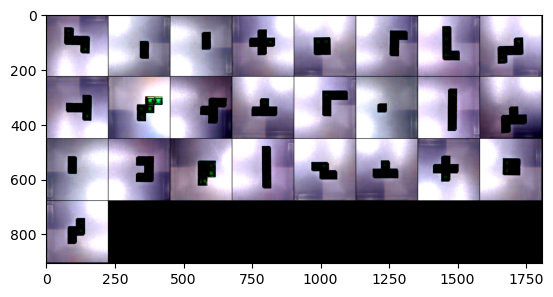

GroundTruth:     Z5    I2    I2     X    O4    L4    L5    Z5    T5     W     F    T4    V5    I1    I5     F    I2     U     P    I5    Z4    T4     X    O4    Z4
Predicted:     Z5    I4    V3     X    O4    L4    L5    V3    T5     W     X     F    V5    I1    I5     F    V3     U     P    I4    Z4     N     X    O4    Z4
Accuracy:  0.68


In [29]:
blockmodel.eval()
batch, labels = next(iter(images['train']))
#Ground Truth
print("Training Data")
imshow(torchvision.utils.make_grid(batch))
print('GroundTruth: ', ' '.join('%5s' % images['classes'][labels[j]] for j in range(len(labels))))

outputs = blockmodel(batch.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % images['classes'][predicted[j]]
                              for j in range(len(labels))))

print("Accuracy: ", accuracy(blockmodel, images['train']))

print("Validation Data")
batch, labels = next(iter(images['val']))
imshow(torchvision.utils.make_grid(batch))
print('GroundTruth: ', ' '.join('%5s' % images['classes'][labels[j]] for j in range(len(labels))))

outputs = blockmodel(batch.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % images['classes'][predicted[j]]
                              for j in range(len(labels))))

print("Accuracy: ", accuracy(blockmodel, images['val']))

print("Test Data")
batch, labels = next(iter(images['test']))
imshow(torchvision.utils.make_grid(batch))
print('GroundTruth: ', ' '.join('%5s' % images['classes'][labels[j]] for j in range(len(labels))))

outputs = blockmodel(batch.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % images['classes'][predicted[j]]
                              for j in range(len(labels))))

print("Accuracy: ", accuracy(blockmodel, images['test']))


In [31]:
torch.save(blockmodel, "BlockModel.pth")